In [ ]:
# import libraries
import os
import sys
import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

import tensorflow as tf
import keras
# from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, Dropout, Input, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.metrics import Precision, Recall, TruePositives
from keras.callbacks import Callback,ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
import keras.backend as K
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%load_ext tensorboard

In [ ]:
# Copy the files from drive to current directory
base = Path('drive/My Drive/Colab Notebooks/')
ds_path = base/'fruits-360/'
sys.path.append(str(base))
# os.chdir(ds_path)
!pwd
!cp -r "{ds_path}" .

/content


In [ ]:
base_dir = './fruits-360/'
train_dir = os.path.join(base_dir, 'Training', '')
test_dir = os.path.join(base_dir, 'Test', '')
print(train_dir)

./fruits-360/Training/


In [ ]:
train_folders = [os.path.join(train_dir, cls) for cls in ['Apple Red 1', 'Avocado', 'Banana', 'Cherry 1', 'Cucumber Ripe', 'Grapefruit Pink', 'Kiwi', 'Lemon']]
X_train = []
for folder in train_folders:
        files = os.listdir(folder)
        for file in files:           
            img_path = os.path.join(folder, file)
            img = load_img(img_path)
            img = img_to_array(img)
            X_train.append(img)
            print('Loaded image: ', img_path)

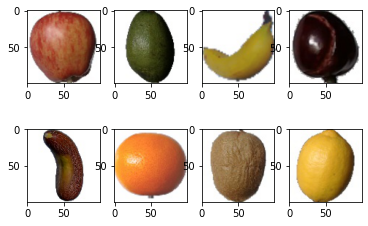

In [ ]:
fig, axs = plt.subplots(2,4)
axs[0,0].imshow(load_img(train_dir + "Apple Red 1/0_100.jpg"))    #492 imgs training
axs[0,1].imshow(load_img(train_dir + "Avocado/0_100.jpg"))        #427 imgs 
axs[0,2].imshow(load_img(train_dir + "Banana/0_100.jpg"))         #490 imgs
axs[0,3].imshow(load_img(train_dir + "Cherry 1/0_100.jpg"))       #492 imgs
axs[1,0].imshow(load_img(train_dir + "Cucumber Ripe/0_100.jpg"))  #392 imgs
axs[1,1].imshow(load_img(train_dir + "Grapefruit Pink/0_100.jpg"))#490 imgs
axs[1,2].imshow(load_img(train_dir + "Kiwi/0_100.jpg"))           #466 imgs
axs[1,3].imshow(load_img(train_dir + "Lemon/0_100.jpg"))          #492 imgs

In [ ]:
# Some hyper-parameters:
img_height = 100
img_width =  100  
input_shape = (img_height, img_width, 3) #resize the input images to this shape
batch_size  = 128        # Images per batch 
num_epochs  = 50       # Max number of training epochs

# Number of classes:
num_classes = 8

Fruits to be chosen for classification:

Apple Red 1, Avocado, Banana, Cherry 1, Cucumber Ripe, Grapefruit Pink, Kiwi, Lemon.

# 1. Artificial Neural Network (ANN)

## Making and training a simple ANN 

In [ ]:
model = Sequential([
# model.add(Input(shape=input_shape))
Flatten(input_shape=input_shape),
Dense(256, activation='sigmoid'), 
Dense(128, activation='sigmoid'), 
Dense(8, activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               7680256   
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 1032      
Total params: 7,714,184
Trainable params: 7,714,184
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])
#f1 score helpful for imbalanced data
#Use sparse categorical crossentropy when your classes are mutually exclusive (e.g. when each sample belongs exactly to one class)

In [ ]:
generator = ImageDataGenerator(validation_split=0.2) # create different generators if I want to augment val data too, using splitfolders.
train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True) #class_mode="sparse" if using sparse_categorical_crossentropy                            
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')
# Also, instead of a val_generator we can have only train_generator and not validation_data and steps but validation_split in fit

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
logdir = os.path.join("./logs/ANN_ab", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)
# %tensorboard --logdir logs

In [ ]:
#save best model
filepath = 'models/ANN_ab.h5'
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(base_dir,filepath), 
                                             monitor = 'val_loss',  
                                             save_best_only=True),
             tensorboard_callback]
#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

In [ ]:
%tensorboard --logdir logs/ANN_ab

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/ANN_ab.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

# Prepeare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

## Normalizing pixel values and adding relu 

Without normalization we have slower than expected training of the model.
Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. As such it is good practice to normalize the pixel values so that each pixel value has a value between 0 and 1.

In [ ]:
model = Sequential([
Flatten(input_shape=input_shape),
Dense(256, activation='relu'), 
Dense(128, activation='relu'), 
Dense(8, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 30000)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               7680256   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
Total params: 7,714,184
Trainable params: 7,714,184
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, validation_split=0.2)

generator.fit(X_train)

train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True) 
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
logdir = os.path.join("./logs/ANN_c", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [ ]:
#save best model
filepath = 'models/ANN_c.h5'
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(base_dir,filepath), monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/50
23/23 [==============================] - 5s 134ms/step - loss: 5.6331 - accuracy: 0.6071 - precision: 0.6549 - recall: 0.5864 - f1_score: 0.5868 - val_loss: 0.1512 - val_accuracy: 0.9766 - val_precision: 0.9766 - val_recall: 0.9766 - val_f1_score: 0.9766
Epoch 2/50
23/23 [==============================] - 2s 104ms/step - loss: 0.0820 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - f1_score: 0.9935 - val_loss: 0.4430 - val_accuracy: 0.9797 - val_precision: 0.9797 - val_recall: 0.9797 - val_f1_score: 0.9797
Epoch 3/50
23/23 [==============================] - 2s 100ms/step - loss: 0.0010 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - f1_score: 0.9997 - val_loss: 0.1736 - val_accuracy: 0.9844 - val_precision: 0.9844 - val_recall: 0.9844 - val_f1_score: 0.9844
Epoch 4/50
23/23 [==============================] - 2s 100ms/step - loss: 4.2434e-04 - accuracy: 0.9998 - precision: 0.9998 - recall: 0.9998 - f1_score: 0.9999 - val_loss: 0.2713 - val_accuracy: 0.9844 

In [ ]:
%tensorboard --logdir logs/ANN_c

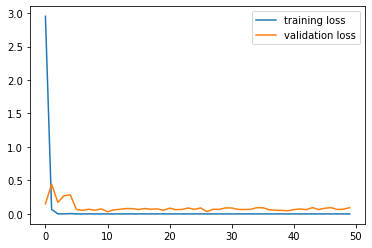

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

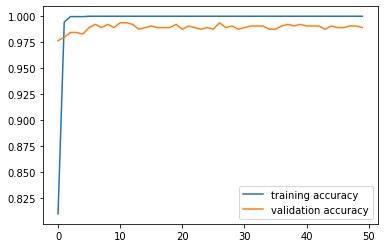

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/ANN_c.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator,)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

10/10 [==============================] - 1s 76ms/step - loss: 0.0118 - accuracy: 0.9957 - precision_1: 0.9957 - recall_1: 0.9957 - f1_score: 0.9957
Test loss:  0.004519493319094181
Test accuracy: 0.9984038472175598
Test precision: 0.9984038472175598
Test recall: 0.9984038472175598
Test f1_score: 0.9984375238418579


Text(0.5, 33.0, 'Predicted label')

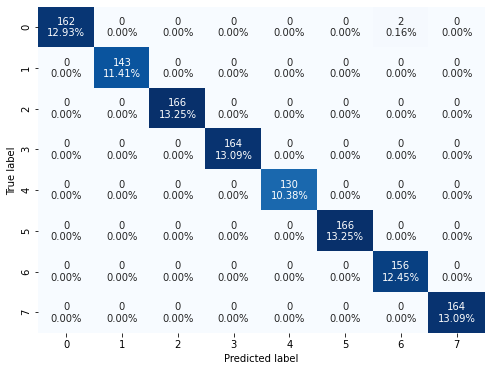

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

## Adding Batch Normalization 

In [ ]:
model = Sequential([
  Flatten(input_shape=input_shape),
  Dense(256, activation='relu'),
  BatchNormalization(),
  Dense(128, activation='relu'),
  BatchNormalization(), 
  Dense(8, activation='softmax')
])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 256)               7680256   
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_28 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_29 (Dense)             (None, 8)                 1032      
Total params: 7,715,720
Trainable params: 7,714,952
Non-trainable params: 768
__________________________________________

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, validation_split=0.2)

generator.fit(X_train)

train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True) 
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
logdir = os.path.join("./logs/ANN_d", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [ ]:
#save best model
filepath = 'models/ANN_d.h5'
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(base_dir,filepath), monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/50
23/23 [==============================] - 4s 130ms/step - loss: 0.7330 - accuracy: 0.7810 - precision_12: 0.8687 - recall_12: 0.7151 - f1_score: 0.7501 - val_loss: 0.6296 - val_accuracy: 0.7422 - val_precision_12: 0.7877 - val_recall_12: 0.6781 - val_f1_score: 0.7289
Epoch 2/50
23/23 [==============================] - 2s 103ms/step - loss: 0.0270 - accuracy: 0.9990 - precision_12: 0.9998 - recall_12: 0.9990 - f1_score: 0.9994 - val_loss: 0.4001 - val_accuracy: 0.8375 - val_precision_12: 0.8678 - val_recall_12: 0.8000 - val_f1_score: 0.8324
Epoch 3/50
23/23 [==============================] - 2s 107ms/step - loss: 0.0098 - accuracy: 0.9996 - precision_12: 0.9996 - recall_12: 0.9996 - f1_score: 0.9996 - val_loss: 0.2272 - val_accuracy: 0.9187 - val_precision_12: 0.9289 - val_recall_12: 0.8781 - val_f1_score: 0.9025
Epoch 4/50
23/23 [==============================] - 2s 107ms/step - loss: 0.0057 - accuracy: 1.0000 - precision_12: 1.0000 - recall_12: 1.0000 - f1_score: 1.0000 - va

In [ ]:
%tensorboard --logdir logs/ANN_d

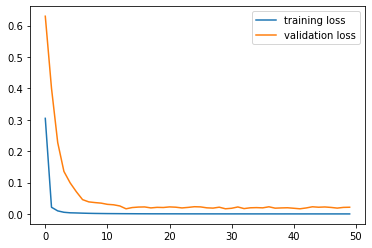

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

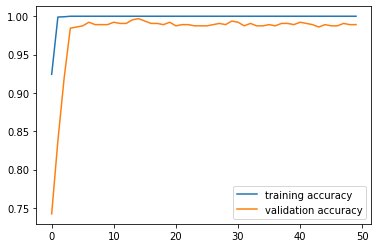

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/ANN_d.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

10/10 [==============================] - 1s 76ms/step - loss: 0.0175 - accuracy: 1.0000 - precision_14: 1.0000 - recall_14: 1.0000 - f1_score: 1.0000
Test loss:  0.012412551790475845
Test accuracy: 1.0
Test precision: 1.0
Test recall: 1.0
Test f1_score: 1.0


Text(0.5, 33.0, 'Predicted label')

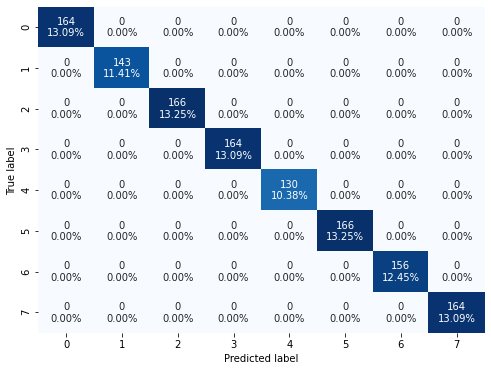

In [ ]:
# model = load_model('fruits-360/models/ANN_d.h5', custom_objects={'f1_score': f1_score})
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

## Experimenting with various ANNs

### 1st experiment: Removing 2nd layer

In [ ]:
model = Sequential([
  Flatten(input_shape=input_shape),
  Dense(256, activation='relu'),
  BatchNormalization(),
  # Dense(128, activation='relu'),
  # BatchNormalization(), 
  Dense(8, activation='softmax')
])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 30000)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               7680256   
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_31 (Dense)             (None, 8)                 2056      
Total params: 7,683,336
Trainable params: 7,682,824
Non-trainable params: 512
_________________________________________________________________


In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, validation_split=0.2)

generator.fit(X_train)

train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True) 
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
logdir = os.path.join("./logs/ANN_e_1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [ ]:
#save best model
filepath = 'models/ANN_e_1.h5'
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(base_dir,filepath), monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/50
23/23 [==============================] - 4s 129ms/step - loss: 0.7525 - accuracy: 0.7818 - precision_13: 0.8872 - recall_13: 0.7108 - f1_score: 0.7595 - val_loss: 0.5731 - val_accuracy: 0.8625 - val_precision_13: 0.8718 - val_recall_13: 0.8609 - val_f1_score: 0.8664
Epoch 2/50
23/23 [==============================] - 2s 103ms/step - loss: 0.0792 - accuracy: 0.9974 - precision_13: 0.9974 - recall_13: 0.9963 - f1_score: 0.9969 - val_loss: 0.3336 - val_accuracy: 0.9234 - val_precision_13: 0.9274 - val_recall_13: 0.9187 - val_f1_score: 0.9231
Epoch 3/50
23/23 [==============================] - 2s 105ms/step - loss: 0.0322 - accuracy: 1.0000 - precision_13: 1.0000 - recall_13: 1.0000 - f1_score: 1.0000 - val_loss: 0.2106 - val_accuracy: 0.9328 - val_precision_13: 0.9386 - val_recall_13: 0.9312 - val_f1_score: 0.9349
Epoch 4/50
23/23 [==============================] - 2s 106ms/step - loss: 0.0167 - accuracy: 0.9986 - precision_13: 0.9986 - recall_13: 0.9986 - f1_score: 0.9988 - va

In [ ]:
%tensorboard --logdir logs/ANN_e_1

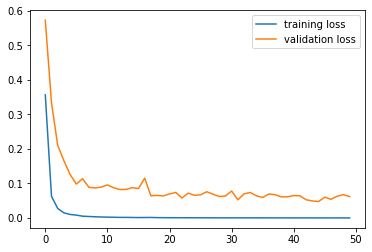

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

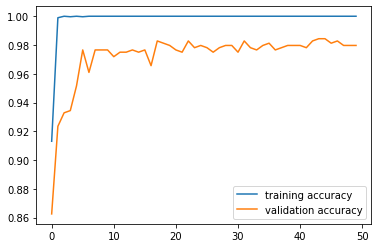

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/ANN_e_1.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

10/10 [==============================] - 1s 77ms/step - loss: 0.0338 - accuracy: 0.9863 - precision_18: 0.9863 - recall_18: 0.9863 - f1_score: 0.9863
Test loss:  0.017859213054180145
Test accuracy: 0.992817223072052
Test precision: 0.992817223072052
Test recall: 0.992817223072052
Test f1_score: 0.992968738079071


Text(0.5, 33.0, 'Predicted label')

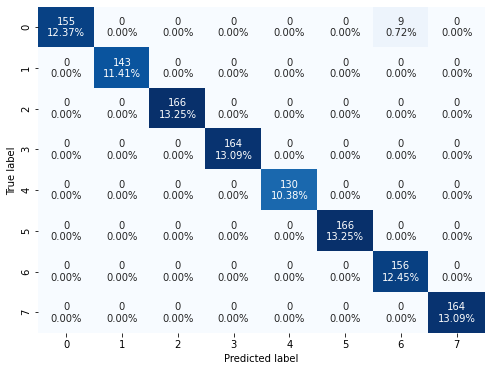

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 2nd experiment: Adding a third layer

In [ ]:
model = Sequential([
  Flatten(input_shape=input_shape),
  Dense(256, activation='relu'),
  BatchNormalization(),
  Dense(128, activation='relu'),
  BatchNormalization(), 
  Dense(64, activation='relu'),
  BatchNormalization(), 
  Dense(8, activation='softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               7680256   
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)               

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, validation_split=0.2)

generator.fit(X_train)

train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True) 
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
import datetime
logdir = os.path.join("./logs/ANN_e_2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)
# %tensorboard --logdir logs

In [ ]:
#save best model
filepath = 'models/ANN_e_2.h5'
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(base_dir,filepath), monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/50
23/23 [==============================] - 4s 129ms/step - loss: 0.8010 - accuracy: 0.7646 - precision_6: 0.8542 - recall_6: 0.6950 - f1_score: 0.7364 - val_loss: 2.6859 - val_accuracy: 0.5125 - val_precision_6: 0.5224 - val_recall_6: 0.5109 - val_f1_score: 0.5167
Epoch 2/50
23/23 [==============================] - 2s 103ms/step - loss: 0.0282 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.0000 - f1_score: 1.0000 - val_loss: 1.5419 - val_accuracy: 0.5750 - val_precision_6: 0.5799 - val_recall_6: 0.5672 - val_f1_score: 0.5735
Epoch 3/50
23/23 [==============================] - 2s 106ms/step - loss: 0.0101 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.0000 - f1_score: 1.0000 - val_loss: 0.8587 - val_accuracy: 0.6047 - val_precision_6: 0.6871 - val_recall_6: 0.5969 - val_f1_score: 0.6388
Epoch 4/50
23/23 [==============================] - 2s 107ms/step - loss: 0.0063 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.0000 - f1_score: 1.0000 - val_loss: 0.4646

In [ ]:
%tensorboard --logdir logs/ANN_e_2

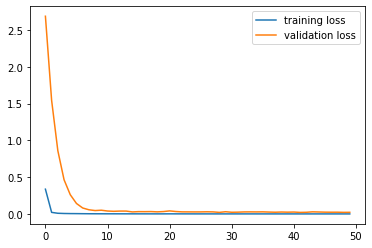

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

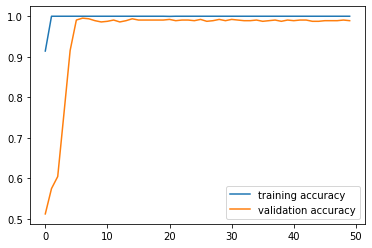

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/ANN_e_2.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

10/10 [==============================] - 1s 77ms/step - loss: 0.0033 - accuracy: 1.0000 - precision_7: 1.0000 - recall_7: 1.0000 - f1_score: 1.0000
Test loss:  0.0018772277981042862
Test accuracy: 1.0
Test precision: 1.0
Test recall: 1.0
Test f1_score: 1.0


Text(0.5, 33.0, 'Predicted label')

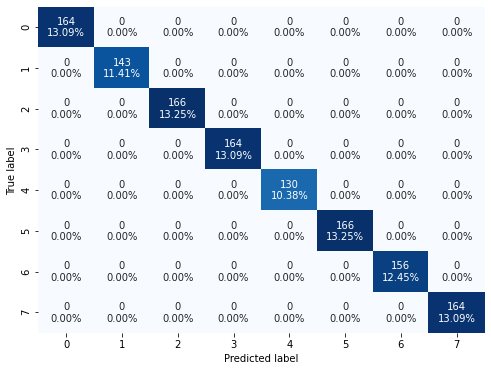

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 3d experiment: Adding more neurons

In [ ]:
model = Sequential([
  Flatten(input_shape=input_shape),
  Dense(1024, activation='relu'),
  BatchNormalization(),
  Dense(256, activation='relu'),
  BatchNormalization(), 
  Dense(8, activation='softmax')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              30721024  
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_14 (Dense)             (None, 256)               262400    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 2056      
Total params: 30,990,600
Trainable params: 30,988,040
Non-trainable params: 2,560
______________________________________

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, validation_split=0.2)

generator.fit(X_train)

train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True) 
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
import datetime
logdir = os.path.join("./logs/ANN_e_3", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [ ]:
#save best model
filepath = 'models/ANN_e_3.h5'
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(base_dir,filepath), monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/50
23/23 [==============================] - 4s 131ms/step - loss: 0.6349 - accuracy: 0.8115 - precision_8: 0.8945 - recall_8: 0.7838 - f1_score: 0.8036 - val_loss: 3.7209 - val_accuracy: 0.6766 - val_precision_8: 0.6766 - val_recall_8: 0.6766 - val_f1_score: 0.6766
Epoch 2/50
23/23 [==============================] - 3s 115ms/step - loss: 0.0149 - accuracy: 0.9989 - precision_8: 0.9989 - recall_8: 0.9988 - f1_score: 0.9988 - val_loss: 2.0772 - val_accuracy: 0.6906 - val_precision_8: 0.6907 - val_recall_8: 0.6875 - val_f1_score: 0.6892
Epoch 3/50
23/23 [==============================] - 2s 106ms/step - loss: 0.0025 - accuracy: 1.0000 - precision_8: 1.0000 - recall_8: 1.0000 - f1_score: 1.0000 - val_loss: 0.8354 - val_accuracy: 0.7078 - val_precision_8: 0.7078 - val_recall_8: 0.7078 - val_f1_score: 0.7078
Epoch 4/50
23/23 [==============================] - 2s 105ms/step - loss: 0.0019 - accuracy: 1.0000 - precision_8: 1.0000 - recall_8: 1.0000 - f1_score: 1.0000 - val_loss: 0.3912

In [ ]:
%tensorboard --logdir logs/ANN_e_3

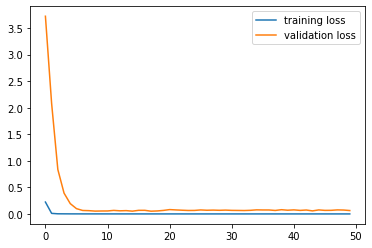

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

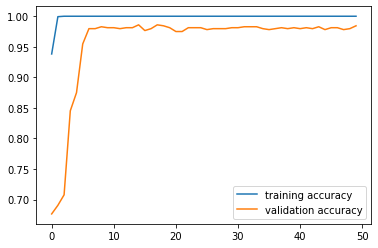

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/ANN_e_3.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

10/10 [==============================] - 1s 79ms/step - loss: 0.0288 - accuracy: 0.9869 - precision_9: 0.9869 - recall_9: 0.9869 - f1_score: 0.9870
Test loss:  0.019095273688435555
Test accuracy: 0.9904229640960693
Test precision: 0.9904229640960693
Test recall: 0.9904229640960693
Test f1_score: 0.9906250238418579


Text(0.5, 33.0, 'Predicted label')

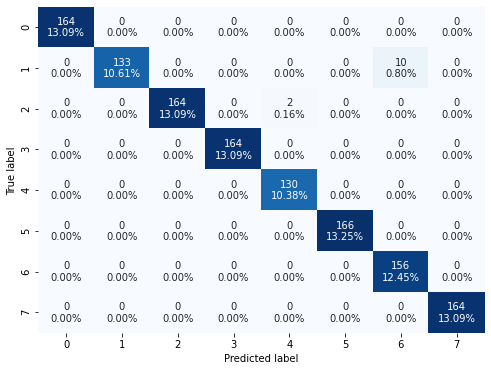

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 4th experiment: SGD optimizer

In [ ]:
model = Sequential([
  Flatten(input_shape=input_shape),
  Dense(256, activation='relu'),
  BatchNormalization(),
  Dense(128, activation='relu'),
  BatchNormalization(), 
  Dense(8, activation='softmax')
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               7680256   
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 1032      
Total params: 7,715,720
Trainable params: 7,714,952
Non-trainable params: 768
__________________________________________

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='SGD', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, validation_split=0.2)

generator.fit(X_train)

train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True) 
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
logdir = os.path.join("./logs/ANN_e_4", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [ ]:
#save best model
filepath = 'models/ANN_e_4.h5'
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(base_dir,filepath), monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/50
23/23 [==============================] - 4s 135ms/step - loss: 0.6089 - accuracy: 0.8121 - precision_10: 0.9039 - recall_10: 0.7929 - f1_score: 0.8153 - val_loss: 1.3012 - val_accuracy: 0.4234 - val_precision_10: 0.5172 - val_recall_10: 0.3984 - val_f1_score: 0.4498
Epoch 2/50
23/23 [==============================] - 2s 104ms/step - loss: 0.0252 - accuracy: 1.0000 - precision_10: 1.0000 - recall_10: 1.0000 - f1_score: 1.0000 - val_loss: 0.6770 - val_accuracy: 0.7281 - val_precision_10: 0.8454 - val_recall_10: 0.6922 - val_f1_score: 0.7611
Epoch 3/50
23/23 [==============================] - 2s 103ms/step - loss: 0.0142 - accuracy: 1.0000 - precision_10: 1.0000 - recall_10: 1.0000 - f1_score: 1.0000 - val_loss: 0.4344 - val_accuracy: 0.8500 - val_precision_10: 0.9449 - val_recall_10: 0.7500 - val_f1_score: 0.8359
Epoch 4/50
23/23 [==============================] - 2s 104ms/step - loss: 0.0112 - accuracy: 1.0000 - precision_10: 1.0000 - recall_10: 1.0000 - f1_score: 1.0000 - va

In [ ]:
%tensorboard --logdir logs/ANN_e_4

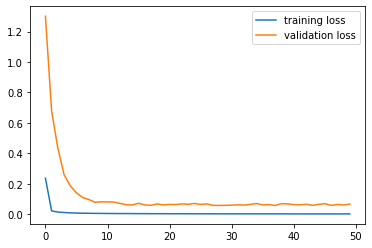

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

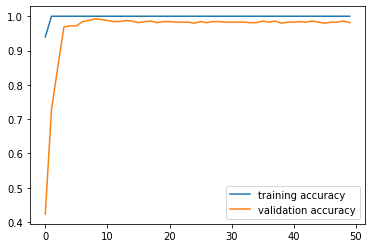

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/ANN_e_4.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

10/10 [==============================] - 1s 78ms/step - loss: 0.0800 - accuracy: 0.9585 - precision_11: 0.9605 - recall_11: 0.9585 - f1_score: 0.9596
Test loss:  0.04678420349955559
Test accuracy: 0.9768555760383606
Test precision: 0.9776358008384705
Test recall: 0.9768555760383606
Test f1_score: 0.9777237176895142


Text(0.5, 33.0, 'Predicted label')

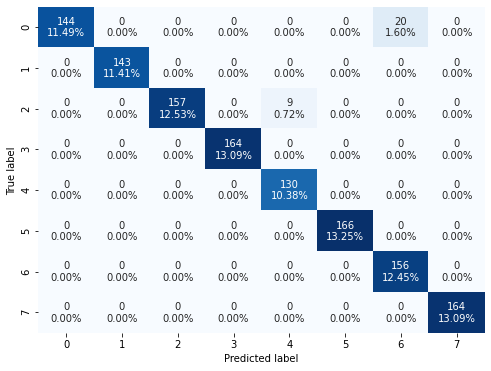

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 5th experiment: Moving relu after BatchNormalization

In [ ]:
model = Sequential([
  Flatten(input_shape=input_shape),
  Dense(256),
  BatchNormalization(),
  Activation('relu'),
  Dense(128),
  BatchNormalization(), 
  Activation('relu'),
  Dense(8, activation='softmax')
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               7680256   
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_8 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)              

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, validation_split=0.2) 

generator.fit(X_train)

train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True) 
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
logdir = os.path.join("./logs/ANN_e_5", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [ ]:
#save best model
filepath = 'models/ANN_e_5.h5'
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(base_dir,filepath), monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/50
23/23 [==============================] - 4s 142ms/step - loss: 0.7618 - accuracy: 0.7751 - precision_12: 0.8914 - recall_12: 0.6886 - f1_score: 0.7345 - val_loss: 1.1684 - val_accuracy: 0.6125 - val_precision_12: 0.6138 - val_recall_12: 0.6109 - val_f1_score: 0.6123
Epoch 2/50
23/23 [==============================] - 2s 103ms/step - loss: 0.0422 - accuracy: 0.9995 - precision_12: 1.0000 - recall_12: 0.9990 - f1_score: 0.9995 - val_loss: 0.4719 - val_accuracy: 0.6766 - val_precision_12: 0.6782 - val_recall_12: 0.6719 - val_f1_score: 0.6750
Epoch 3/50
23/23 [==============================] - 2s 103ms/step - loss: 0.0214 - accuracy: 0.9998 - precision_12: 0.9998 - recall_12: 0.9991 - f1_score: 0.9995 - val_loss: 0.2682 - val_accuracy: 0.8484 - val_precision_12: 0.9020 - val_recall_12: 0.8344 - val_f1_score: 0.8668
Epoch 4/50
23/23 [==============================] - 2s 105ms/step - loss: 0.0104 - accuracy: 1.0000 - precision_12: 1.0000 - recall_12: 1.0000 - f1_score: 1.0000 - va

In [ ]:
%tensorboard --logdir logs/ANN_e_5

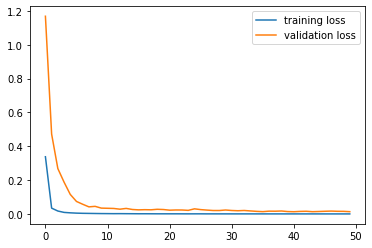

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

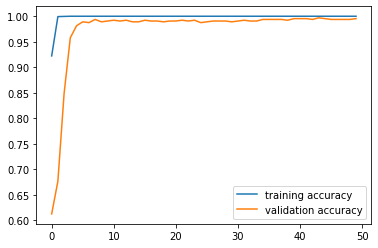

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/ANN_e_5.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

10/10 [==============================] - 2s 78ms/step - loss: 0.0168 - accuracy: 1.0000 - precision_13: 1.0000 - recall_13: 1.0000 - f1_score: 1.0000
Test loss:  0.00850736629217863
Test accuracy: 1.0
Test precision: 1.0
Test recall: 1.0
Test f1_score: 1.0


Text(0.5, 33.0, 'Predicted label')

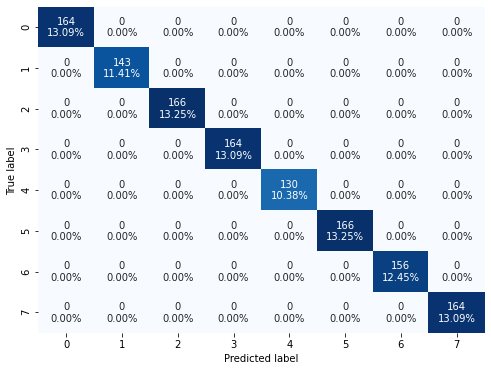

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 6th experiment: Rescale = 1/255

In [ ]:
model = Sequential([
  Flatten(input_shape=input_shape),
  Dense(256, activation='relu'),
  BatchNormalization(),
  Dense(128, activation='relu'),
  BatchNormalization(), 
  Dense(8, activation='softmax')
])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 30000)             0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               7680256   
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)               1024      
_________________________________________________________________
dense_32 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_16 (Batc (None, 128)               512       
_________________________________________________________________
dense_33 (Dense)             (None, 8)                 1032      
Total params: 7,715,720
Trainable params: 7,714,952
Non-trainable params: 768
_________________________________________

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
generator = ImageDataGenerator(rescale=1./255, validation_split=0.2) 

generator.fit(X_train)

train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True) 
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
logdir = os.path.join("./logs/ANN_e_6", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [ ]:
#save best model
filepath = 'models/ANN_e_6.h5'
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(base_dir,filepath), monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/50
23/23 [==============================] - 4s 126ms/step - loss: 0.8279 - accuracy: 0.7385 - precision_17: 0.8761 - recall_17: 0.6704 - f1_score: 0.7223 - val_loss: 15.2663 - val_accuracy: 0.1344 - val_precision_17: 0.1344 - val_recall_17: 0.1344 - val_f1_score: 0.1344
Epoch 2/50
23/23 [==============================] - 2s 89ms/step - loss: 0.0307 - accuracy: 0.9987 - precision_17: 1.0000 - recall_17: 0.9987 - f1_score: 0.9993 - val_loss: 4.9217 - val_accuracy: 0.1719 - val_precision_17: 0.1464 - val_recall_17: 0.1375 - val_f1_score: 0.1420
Epoch 3/50
23/23 [==============================] - 2s 88ms/step - loss: 0.0097 - accuracy: 1.0000 - precision_17: 1.0000 - recall_17: 1.0000 - f1_score: 1.0000 - val_loss: 2.5427 - val_accuracy: 0.1953 - val_precision_17: 0.1780 - val_recall_17: 0.1719 - val_f1_score: 0.1747
Epoch 4/50
23/23 [==============================] - 2s 89ms/step - loss: 0.0059 - accuracy: 1.0000 - precision_17: 1.0000 - recall_17: 1.0000 - f1_score: 1.0000 - val_

In [ ]:
%tensorboard --logdir logs/ANN_e_6

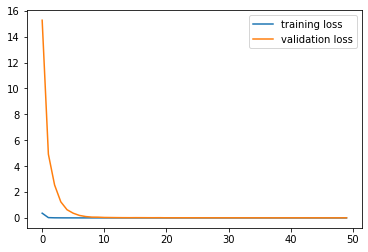

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

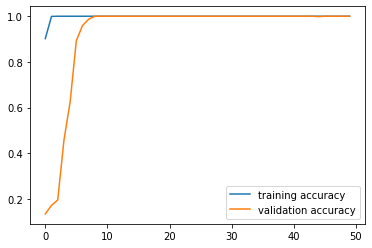

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/ANN_e_6.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

10/10 [==============================] - 1s 68ms/step - loss: 0.0291 - accuracy: 0.9935 - precision_18: 0.9935 - recall_18: 0.9935 - f1_score: 0.9935
Test loss:  0.013837046921253204
Test accuracy: 0.9976057410240173
Test precision: 0.9976057410240173
Test recall: 0.9976057410240173
Test f1_score: 0.9976562261581421


Text(0.5, 33.0, 'Predicted label')

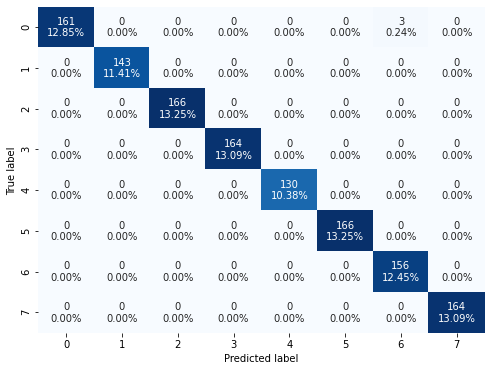

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 7th experiment: Adding Dropout

In [ ]:
model = Sequential([
  Flatten(input_shape=input_shape),
  Dense(256, activation='relu'),
  Dropout(0.2),
  BatchNormalization(),
  Dense(128, activation='relu'),
  Dropout(0.2),
  BatchNormalization(), 
  Dense(8, activation='softmax')
])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               7680256   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
dense_26 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 128)              

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, validation_split=0.2)

generator.fit(X_train)

train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True) 
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
logdir = os.path.join("./logs/ANN_e_7", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [ ]:
#save best model
filepath = 'models/ANN_e_7.h5'
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(base_dir,filepath), monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/50
23/23 [==============================] - 4s 129ms/step - loss: 1.0488 - accuracy: 0.6726 - precision_15: 0.8023 - recall_15: 0.5253 - f1_score: 0.6116 - val_loss: 0.3916 - val_accuracy: 0.8000 - val_precision_15: 0.9385 - val_recall_15: 0.7625 - val_f1_score: 0.8411
Epoch 2/50
23/23 [==============================] - 2s 104ms/step - loss: 0.1235 - accuracy: 0.9723 - precision_15: 0.9787 - recall_15: 0.9639 - f1_score: 0.9720 - val_loss: 0.1147 - val_accuracy: 1.0000 - val_precision_15: 1.0000 - val_recall_15: 0.9984 - val_f1_score: 0.9992
Epoch 3/50
23/23 [==============================] - 2s 104ms/step - loss: 0.0483 - accuracy: 0.9930 - precision_15: 0.9951 - recall_15: 0.9922 - f1_score: 0.9937 - val_loss: 0.0653 - val_accuracy: 0.9969 - val_precision_15: 1.0000 - val_recall_15: 0.9906 - val_f1_score: 0.9953
Epoch 4/50
23/23 [==============================] - 2s 104ms/step - loss: 0.0260 - accuracy: 0.9981 - precision_15: 0.9996 - recall_15: 0.9971 - f1_score: 0.9984 - va

In [ ]:
%tensorboard --logdir logs/ANN_e_7

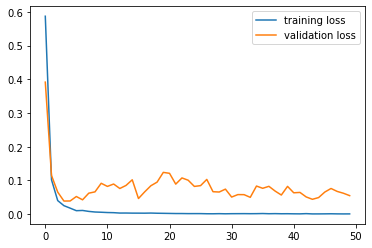

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

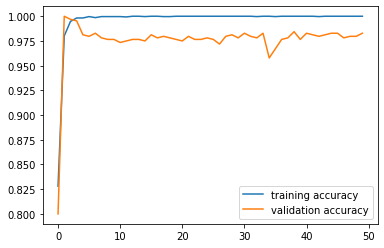

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/ANN_e_7.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

10/10 [==============================] - 1s 78ms/step - loss: 0.0142 - accuracy: 1.0000 - precision_16: 1.0000 - recall_16: 1.0000 - f1_score: 1.0000
Test loss:  0.024540625512599945
Test accuracy: 1.0
Test precision: 1.0
Test recall: 1.0
Test f1_score: 1.0


Text(0.5, 33.0, 'Predicted label')

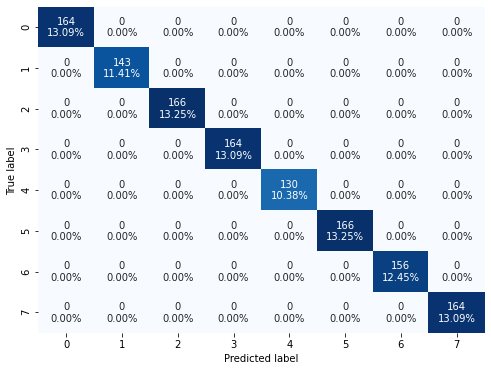

In [ ]:
# model = load_model('fruits-360/models/ANN_d.h5', custom_objects={'f1_score': f1_score})
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 8th experiment: Mixing 2nd and 7th experiment

In [ ]:
model = Sequential([
  Flatten(input_shape=input_shape),
  Dense(256, activation='relu'),
  Dropout(0.2),
  BatchNormalization(),
  Dense(128, activation='relu'),
  Dropout(0.2),
  BatchNormalization(), 
  Dense(64, activation='relu'),
  Dropout(0.2),
  BatchNormalization(), 
  Dense(8, activation='softmax')
])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 30000)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               7680256   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
dense_37 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 128)             

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, validation_split=0.2)

generator.fit(X_train)

train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True) 
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
logdir = "./logs/ANN_e_8"
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)
# %tensorboard --logdir logs

In [ ]:
#save best model
filepath = 'models/ANN_e_8.h5'
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(base_dir,filepath), monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/50
23/23 [==============================] - 4s 139ms/step - loss: 1.5910 - accuracy: 0.4545 - precision_21: 0.6214 - recall_21: 0.2865 - f1_score: 0.3619 - val_loss: 1.6919 - val_accuracy: 0.6906 - val_precision_21: 0.7920 - val_recall_21: 0.6844 - val_f1_score: 0.7341
Epoch 2/50
23/23 [==============================] - 2s 108ms/step - loss: 0.4344 - accuracy: 0.8928 - precision_21: 0.9534 - recall_21: 0.7790 - f1_score: 0.8562 - val_loss: 0.4710 - val_accuracy: 0.8484 - val_precision_21: 0.9782 - val_recall_21: 0.8422 - val_f1_score: 0.9050
Epoch 3/50
23/23 [==============================] - 3s 110ms/step - loss: 0.1912 - accuracy: 0.9708 - precision_21: 0.9834 - recall_21: 0.9477 - f1_score: 0.9651 - val_loss: 0.2023 - val_accuracy: 0.9578 - val_precision_21: 0.9661 - val_recall_21: 0.8453 - val_f1_score: 0.9016
Epoch 4/50
23/23 [==============================] - 2s 108ms/step - loss: 0.1000 - accuracy: 0.9925 - precision_21: 0.9956 - recall_21: 0.9835 - f1_score: 0.9898 - va

In [ ]:
%tensorboard --logdir logs/ANN_e_8

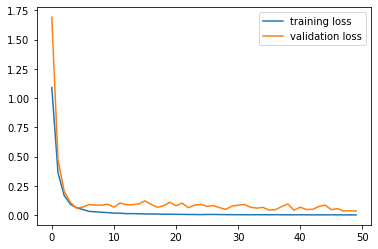

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

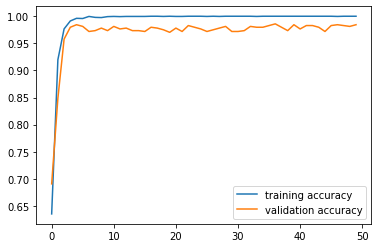

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/ANN_e_8.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

10/10 [==============================] - 1s 81ms/step - loss: 6.4412e-04 - accuracy: 1.0000 - precision_22: 1.0000 - recall_22: 1.0000 - f1_score: 1.0000
Test loss:  0.00036913034273311496
Test accuracy: 1.0
Test precision: 1.0
Test recall: 1.0
Test f1_score: 1.0


Text(0.5, 33.0, 'Predicted label')

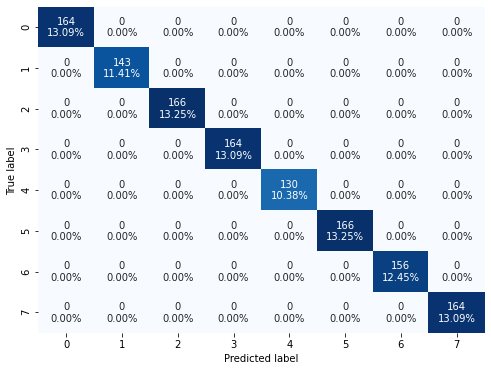

In [ ]:
# model = load_model('fruits-360/models/ANN_d.h5', custom_objects={'f1_score': f1_score})
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')